Skboost

Dit is het gemakkelijkste 

In [1]:
!pip uninstall -y skboost
!pip install git+https://github.com/tibovanheule/skboost

Found existing installation: skboost 0.2.1
Uninstalling skboost-0.2.1:
  Successfully uninstalled skboost-0.2.1
  Cloning https://github.com/tibovanheule/skboost to /private/var/folders/dc/1bymglpd6198p4cqkyfcnrqw0000gn/T/pip-req-build-kdduu8jk
  Running command git clone --filter=blob:none --quiet https://github.com/tibovanheule/skboost /private/var/folders/dc/1bymglpd6198p4cqkyfcnrqw0000gn/T/pip-req-build-kdduu8jk
  Resolved https://github.com/tibovanheule/skboost to commit 14507560afbfc50cb5a6417cab8e4023b3b58941
  Preparing metadata (setup.py) ... done
  Created wheel for skboost: filename=skboost-0.2.1-cp39-cp39-macosx_10_14_x86_64.whl size=1448199 sha256=d05f7b7d28527d087ed6081c170438f1d060148cd8957e06bb4c3fd857409190
  Stored in directory: /private/var/folders/dc/1bymglpd6198p4cqkyfcnrqw0000gn/T/pip-ephem-wheel-cache-waehtpx0/wheels/7a/33/f3/8e5515be575c1c6dee7455e8f99f7683f69af9f06e07a7de02
Successfully built skboost


In [4]:
import skboost
help(skboost.milboost.softmax)

Help on package skboost.milboost.softmax in skboost.milboost:

NAME
    skboost.milboost.softmax - # -*- coding: utf-8 -*-

PACKAGE CONTENTS
    base
    gm
    isr
    lse
    nor

CLASSES
    skboost.milboost.softmax.base.SoftmaxFunction(builtins.object)
        skboost.milboost.softmax.gm.GeneralizedMean
        skboost.milboost.softmax.isr.ISR
        skboost.milboost.softmax.lse.LogSumExponential
        skboost.milboost.softmax.nor.NoisyOR
    
    class GeneralizedMean(skboost.milboost.softmax.base.SoftmaxFunction)
     |  GeneralizedMean(*args)
     |  
     |  The Generalized Mean softmax function.
     |  
     |  Method resolution order:
     |      GeneralizedMean
     |      skboost.milboost.softmax.base.SoftmaxFunction
     |      builtins.object
     |  
     |  Methods defined here:
     |  
     |  __init__(self, *args)
     |      Initialize self.  See help(type(self)) for accurate signature.
     |  
     |  __str__(self)
     |      Return str(self).
     |  
     |

In [1]:
from skboost import milboost
help(milboost.classifier.MILBoostClassifier)

Help on class MILBoostClassifier in module skboost.milboost.classifier:

class MILBoostClassifier(sklearn.base.ClassifierMixin, sklearn.ensemble._weight_boosting.BaseWeightBoosting)
 |  MILBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), softmax=None, n_estimators=50, learning_rate=1.0, random_state=None, verbose=False)
 |  
 |  Method resolution order:
 |      MILBoostClassifier
 |      sklearn.base.ClassifierMixin
 |      sklearn.ensemble._weight_boosting.BaseWeightBoosting
 |      sklearn.ensemble._base.BaseEnsemble
 |      sklearn.base.MetaEstimatorMixin
 |      sklearn.base.BaseEstimator
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, base_estimator=DecisionTreeClassifier(max_depth=10), softmax=None, n_estimators=50, learning_rate=1.0, random_state=None, verbose=False)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  decision_function(self, X)
 |      

In [1]:
from loader import parse_c45, bag_set
from __future__ import print_function, division
from sklearn.model_selection import StratifiedKFold
from skboost.milboost.classifier import MILBoostClassifier
from skboost.milboost.softmax import *
from score import result
import numpy as np
import time


In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import time
import logging
import matplotlib.pyplot as plt

def result(algo,y_true,y_pred,time_ep,k_fold):
    epoch_time = int(time.time())
    logging.info("saving results ...")

    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    #
    # Print the confusion matrix using Matplotlib
    #
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.savefig(str("compare/"+str(epoch_time)),dpi=300)
    plt.clf()

    report = classification_report(y_true=y_true, y_pred=y_pred,output_dict=True)
    print(report)
    names = ["algo", "k_fold", "time_running","time","acc"]
    acc = 
    names += [ up +"_" + lo for up in report for lo in report[str(up)]]
    
    file_path = Path("compare/score.csv")
    if not file_path.is_file():
        with open(file_path,"a") as file:
            file.write(",".join(names)+"\n")
    with open(file_path,"a") as file:
        result = [algo, k_fold, epoch_time,time_ep]
        result += [ report[upper][lo] for upper in report for lo in report[upper]]
        file.write(",".join(result)+"\n")

In [22]:
# Load list of C4.5 Examples
example_set = parse_c45('fox')

# Get stats to normalize data
raw_data = np.array(example_set.to_float())
data_mean = np.average(raw_data, axis=0)
data_std  = np.std(raw_data, axis=0)
data_std[np.nonzero(data_std == 0.0)] = 1.0
def normalizer(ex):
    ex = np.array(ex)
    return ex


# Group examples into bags
bagset = bag_set(example_set)

molecule_names = []
conformation_names = []
bags = []
labels = []

bag_id = 0
for bag in bagset: 
    for ro in bag.to_float(normalizer):
        if ro[0] not in molecule_names:
            molecule_names.append(ro[0])
            bag_id += 1
        labels.append(int(((float(ro[-1]) * 2) - 1)))
        conformation_names.append(ro[1])
        bags.append(list(map(float, ro[2:-1])))

bags = np.array(bags,dtype="float")
labels = np.array(labels,dtype="int")
        
fold = StratifiedKFold(n_splits=5, shuffle=False, random_state=None)
splittt = 1
for train_index, test_index in fold.split(bags,labels):
    X_train, X_test = bags[train_index], bags[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    epoch_time = time.time()
    model = MILBoostClassifier(softmax=LogSumExponential(5.0))
    model.fit(X_train,y_train)
    start = time.time()
    predicted = model.predict(X_test)
    time_ep = time.time() - start
    result("MILboost",y_test,predicted,time_ep, splittt)
    splittt += 1
    

{'-1': {'precision': 0.6299212598425197, 'recall': 0.5970149253731343, 'f1-score': 0.6130268199233716, 'support': 134}, '1': {'precision': 0.6058394160583942, 'recall': 0.6384615384615384, 'f1-score': 0.6217228464419475, 'support': 130}, 'accuracy': 0.6174242424242424, 'macro avg': {'precision': 0.6178803379504569, 'recall': 0.6177382319173363, 'f1-score': 0.6173748331826596, 'support': 264}, 'weighted avg': {'precision': 0.6180627761609426, 'recall': 0.6174242424242424, 'f1-score': 0.6173089541938825, 'support': 264}}


TypeError: 'float' object is not iterable

<Figure size 750x750 with 0 Axes>

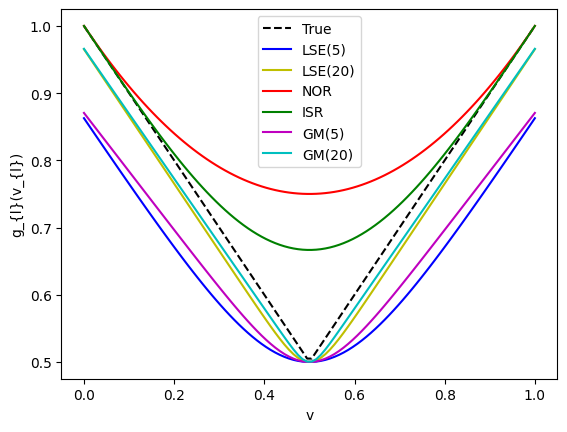

In [7]:
import matplotlib.pyplot as plt

x = np.linspace(0.0, 1.0, num=100)
t = np.vstack([x, 1 - x]).T
true_t = np.max(t, axis=1)

lse_5 = list(map(LogSumExponential(5.0).f, t))
lse_20 = list(map(LogSumExponential(20.0).f, t))
nor = list(map(NoisyOR().f, t))
isr = list(map(ISR().f, t))
gm_5 = list(map(GeneralizedMean(5.0).f, t))
gm_20 = list(map(GeneralizedMean(20.0).f, t))

plt.plot(x, true_t, 'k--', label='True')
plt.plot(x, lse_5, 'b', label='LSE(5)')
plt.plot(x, lse_20, 'y', label='LSE(20)')
plt.plot(x, nor, 'r', label='NOR')
plt.plot(x, isr, 'g', label='ISR')
plt.plot(x, gm_5, 'm', label='GM(5)')
plt.plot(x, gm_20, 'c', label='GM(20)')

plt.legend()
plt.xlabel('v')
plt.ylabel('g_{l}(v_{l})')

plt.show()

